# Simple Generative Adversarial Networks  (GAN) 

 Les GANs utilisent un cadre de compétition entre un générateur et un discriminateur. Le générateur crée des données afin de tromper le discriminateur, tandis que le discriminateur tente de distinguer les données générées de celles réelles.

 Les GANs n'apprennent pas explicitement une représentation structurée de l'espace latent, mais ils génèrent des données directement à partir de bruit aléatoire.

 Les GANs sont entraînés à travers un processus de jeu entre le générateur et le discriminateur, où le générateur tente de minimiser la capacité du discriminateur à distinguer les données générées de celles réelles.

 Les GANs peuvent générer des données de manière impressionnante, mais l'espace latent n'est pas toujours interprétable de manière directe, et la structuration peut être plus complexe.

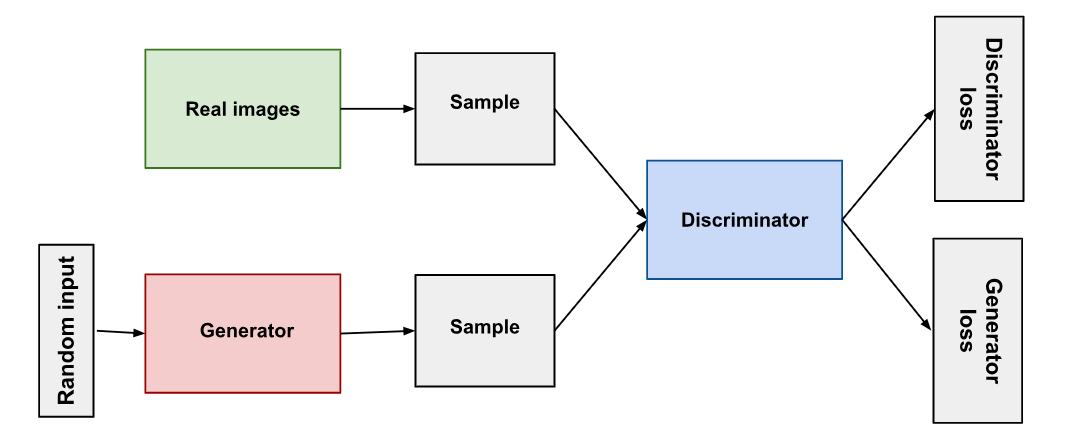

Dans un Generative Adversarial Network (GAN), le générateur et le discriminateur ont des rôles spécifiques dans un processus de jeu adversatif. Voici une explication des inputs et outputs typiques pour le générateur et le discriminateur dans un GAN :

1. **Générateur :**
   - **Input (Entrée) :** Le générateur prend généralement en entrée un vecteur aléatoire ou un bruit, souvent noté $\(z\)$, qui est échantillonné à partir d'une distribution simple comme une distribution normale.
   - **Output (Sortie) :** Le générateur produit en sortie une image ou une donnée synthétique. Cette sortie est souvent notée $\(G(z)\)$, où $\(G\)$ représente la fonction génératrice.

2. **Discriminateur :**
   - **Input (Entrée) :** Le discriminateur prend en entrée une donnée, qui peut être soit une vraie donnée d'entraînement $(\(x\))$ soit une donnée générée par le générateur $(\(G(z)\))$.
   - **Output (Sortie) :** Le discriminateur produit en sortie une probabilité, indiquant s'il estime que l'entrée est une vraie donnée $(\(D(x)\))$ ou une donnée générée $(\(D(G(z))\))$. Typiquement, $\(D(x)\)$ et $\(D(G(z))\)$ sont des nombres réels entre 0 et 1, où des valeurs proches de 1 indiquent une classification comme vraie donnée et des valeurs proches de 0 indiquent une classification comme donnée générée.

**Processus de l'entraînement GAN :**
   - Le générateur cherche à produire des données qui sont de plus en plus difficiles à distinguer des données réelles par le discriminateur.
   - Le discriminateur est entraîné pour améliorer sa capacité à distinguer entre les données réelles et générées.
   - Ce processus d'entraînement par compétition se poursuit jusqu'à ce que le générateur produise des données indiscernables de celles réelles selon le discriminateur.

Le GAN est donc basé sur l'idée d'un jeu entre le générateur et le discriminateur, où le générateur cherche à tromper le discriminateur en produisant des données indiscernables de celles réelles, et le discriminateur cherche à devenir de plus en plus précis dans sa classification. Ce processus itératif conduit éventuellement à la génération de données de haute qualité.

## Importing libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# Model

## Discriminator Class

+ Discriminateur (Discriminator):

Le discriminateur prend en entrée des images de dimension img_dim (par exemple, 28 * 28 * 1 pour les images MNIST après aplatissement).
Il utilise une séquence de couches linéaires suivies d'activations LeakyReLU.
La sortie finale est obtenue à l'aide d'une couche linéaire suivie d'une activation sigmoid pour produire une probabilité que l'image soit réelle (entre 0 et 1).

In [2]:
class Discriminator(nn.Module):
    def  __init__(self, img_dim) -> None:
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(img_dim, 128),
            nn.LeakyReLU(0.1),
            nn.Linear(128,1),
            nn.Sigmoid(),
        )
    def forward(self,x):
        return self.disc(x)

## Generator Class

- Générateur (Generator):

Le générateur prend en entrée un vecteur de bruit de dimension z_dim (par exemple, 100 pour le bruit gaussien standard).
Il utilise une séquence de couches linéaires suivies d'activations LeakyReLU.
La sortie finale est obtenue à l'aide d'une couche linéaire suivie d'une activation Tanh pour produire des valeurs entre -1 et 1, ce qui est typique pour les images MNIST normalisées.

In [3]:
class Generator(nn.Module):
    def  __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim), # MNIMST 28*28*1
            nn.Tanh(),
        )
    def forward(self,x):
        return self.gen(x)

## Config Hyperparameters

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-5
z_dim = 64
image_dim = 28*28*1
batch_size = 64
num_epochs = 50

## Load and transform  MNIST dataset

In [5]:
# Crée une instance du modèle Discriminator avec la dimension d'image spécifiée et le déplace sur le dispositif (CPU ou GPU).
discriminator = Discriminator(image_dim).to(device)
# Crée une instance du modèle Generator avec les dimensions de bruit et d'image spécifiées et le déplace sur le dispositif.
generator = Generator(z_dim, image_dim).to(device)
# Génère un vecteur de bruit fixe qui sera utilisé pour visualiser la progression de la génération pendant l'entraînement.
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
# Définit les transformations pour prétraiter les images MNIST : conversion en tenseur et normalisation.
transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))] # moyenne et écart-type de MNIST
)
# Télécharge le jeu de données MNIST et applique les transformations spécifiées.
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
# Crée un DataLoader pour faciliter l'itération sur les mini-batchs du jeu de données.
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# Initialise les optimiseurs Adam pour le discriminateur et le générateur avec le taux d'apprentissage spécifié.
opt_disc = optim.Adam(discriminator.parameters(), lr=lr)
opt_gen = optim.Adam(generator.parameters(), lr=lr)
# Définit la fonction de perte binaire entropique croisée (BCE) pour mesurer l'erreur entre les prédictions et les vraies étiquettes.
criterion = nn.BCELoss()
# Initialise les objets SummaryWriter pour enregistrer les statistiques dans TensorBoard pour la visualisation.
writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
# Initialise le compteur d'étapes pour suivre le nombre total d'itérations d'entraînement.
step = 0

In [8]:
print(loader)

## Training and callback result to tensorboad

- Training Discriminator:

Generate random noise and pass it through the generator to create fake images.
Compute the discriminator's prediction for real and fake images.
Calculate the binary cross-entropy loss for real and fake images.
Compute the average loss and perform backpropagation on the discriminator.
Update discriminator's parameters using the optimizer.

- Training Generator:

Generate fake images using the generator.
Pass the fake images through the discriminator.
Calculate the binary cross-entropy loss.
Perform backpropagation on the generator.
Update generator's parameters using the optimizer.

- Tensorboard Visualization:

Print and log the losses for Discriminator and Generator.
Create image grids for real and fake images.
Add these image grids to Tensorboard for visualization.
Increment the step counter for Tensorboard logging.

In [14]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1,784).to(device)
        batch_size = real.shape[0]
        ### Train Discriminator: max (log(D(real)) + log(1 - D(fake)))
        noise = torch.randn(batch_size, z_dim).to(device)  # random noise
        fake = generator(noise)                          # generate a fake image
        disc_real = discriminator(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = discriminator(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2 
        discriminator.zero_grad()
        lossD.backward(retain_graph=True)
        opt_disc.step()

        ### Train Discriminator: min (log(1 - D(G(z)) --> max log(D(G(z))))
        output = discriminator(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        generator.zero_grad()
        lossG.backward()
        opt_gen.step()
        
        ## tensorboard
        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = generator(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/50] Batch 0/938                       Loss D: 0.6777, loss G: 0.7149
Epoch [1/50] Batch 0/938                       Loss D: 0.5810, loss G: 0.5340
Epoch [2/50] Batch 0/938                       Loss D: 0.5731, loss G: 0.5959
Epoch [3/50] Batch 0/938                       Loss D: 0.4914, loss G: 0.7129
Epoch [4/50] Batch 0/938                       Loss D: 0.4439, loss G: 0.7478
Epoch [5/50] Batch 0/938                       Loss D: 0.4382, loss G: 0.7174
Epoch [6/50] Batch 0/938                       Loss D: 0.4441, loss G: 0.6634
Epoch [7/50] Batch 0/938                       Loss D: 0.4113, loss G: 0.7378
Epoch [8/50] Batch 0/938                       Loss D: 0.3947, loss G: 0.8238
Epoch [9/50] Batch 0/938                       Loss D: 0.3806, loss G: 0.8613
Epoch [10/50] Batch 0/938                       Loss D: 0.3734, loss G: 0.8804
Epoch [11/50] Batch 0/938                       Loss D: 0.3594, loss G: 0.9177
Epoch [12/50] Batch 0/938                       Loss D: 0.3370